In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

### Ładowanie danych

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

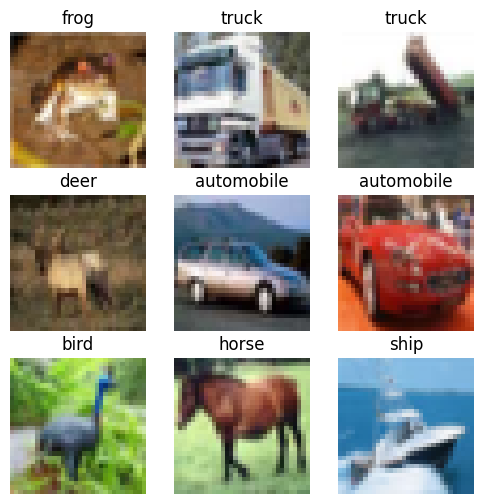

In [4]:
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i])
    plt.title(labels[y_train[i][0]])
    plt.axis("off")
plt.show()

In [5]:
print(x_train.shape)

(50000, 32, 32, 3)


Rozkład klas w zbiorze treningowym

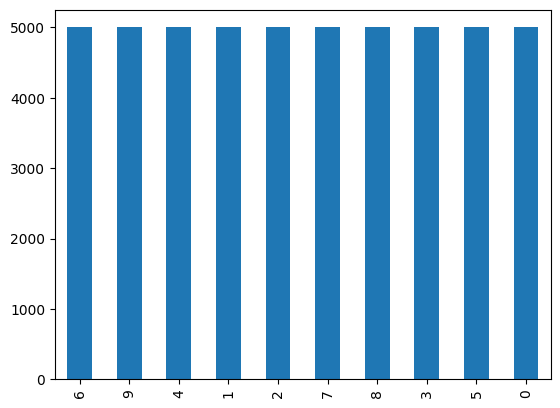

In [6]:
df = pd.DataFrame(y_train)
df.columns = ['labels']
df.labels.value_counts().plot(kind = 'bar')
plt.show()

Rozkład klas w testowym

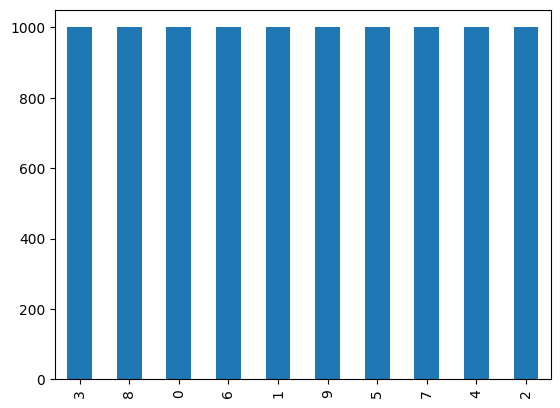

In [7]:
df = pd.DataFrame(y_test)
df.columns = ['labels']
df.labels.value_counts().plot(kind = 'bar')
plt.show()

Dane są zbalansowane, wszystkich klas jest tyle samo

Skalowanie danych

In [8]:
x_train = x_train / 255.0
x_test = x_test / 255.0

## Wydzielenie zbioru walidacyjnego

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42, stratify = y_train)

Rozkład klas w walidacyjnym

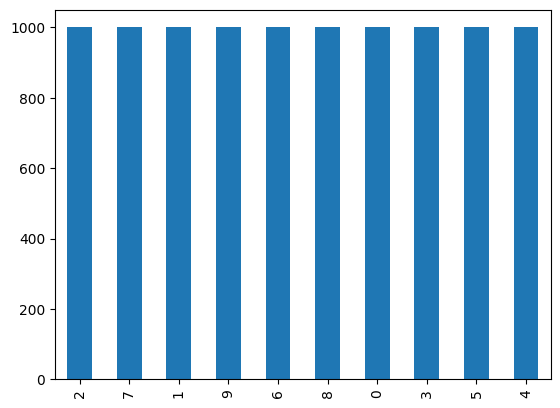

In [10]:
df = pd.DataFrame(y_val)
df.columns = ['labels']
df.labels.value_counts().plot(kind = 'bar')
plt.show()

Rozkład klas w treningowm po wydzieleniu walidacyjnego

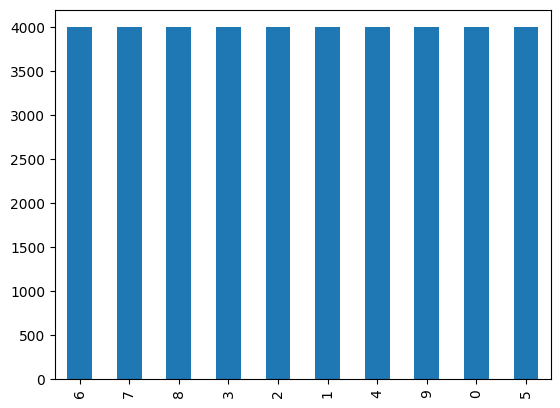

In [11]:
df = pd.DataFrame(y_train)
df.columns = ['labels']
df.labels.value_counts().plot(kind = 'bar')
plt.show()

In [12]:
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
METRICS_AND_PARAMS = {}

Metody do zbierania wyników

In [13]:
from sklearn.metrics import f1_score

def get_evaluated_metrics(model, X_val, y_val):
    loss, accuracy = model.evaluate(X_val, y_val)
    y_pred = tf.argmax(model.predict(X_val), axis=1)
    f1 = f1_score(y_val, y_pred, average='micro', zero_division=0)

    return loss, accuracy, f1

def collect_metrics_and_params(model, X_val, y_val, epochs, number_of_convs, activation_hidden, activation_output, dropout_rate = None, regularizer = None, optimizer = None):
    global METRICS_AND_PARAMS

    loss, accuracy, f1 = get_evaluated_metrics(model, X_val, y_val)

    metrics_dict = {}
    metrics_dict["loss"] = loss
    metrics_dict["f1_score"] = f1
    metrics_dict["accuracy"] = accuracy
    metrics_dict["epochs"] = epochs
    metrics_dict["number_of_layers"] = number_of_convs
    metrics_dict["dropout_rate"] = dropout_rate
    metrics_dict["regularizer"] = regularizer
    metrics_dict["optimizer"] = optimizer
    metrics_dict["activation_hidden"] = activation_hidden
    metrics_dict["activation_output"] = activation_output

    METRICS_AND_PARAMS[len(METRICS_AND_PARAMS)] = metrics_dict

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

## Wyświetlenie przebiegu uczenia (historia dokładności i historia straty)

In [15]:
def draw_history_accuracy_and_loss(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  ax1.plot(history.history['accuracy'], label = 'accuracy')
  ax1.plot(history.history['val_accuracy'], label = 'val_accuracy')
  ax1.legend()

  ax2.plot(history.history['loss'], label = 'loss')
  ax2.plot(history.history['val_loss'], label = 'val_loss')
  ax2.legend()
  plt.show()

In [16]:
def create_model(epochs, number_of_convs, activation_hidden, activation_output, dropout_rate, regularizer, optimizer):
  model = Sequential()
  model.add(Conv2D(32, KERNEL_SIZE, activation = activation_hidden, padding = 'same', input_shape = INPUT_SHAPE))

  for i in range(number_of_convs):
    model.add(Conv2D(32, KERNEL_SIZE, activation = activation_hidden, padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(dropout_rate))

  model.add(Flatten())
  model.add(Dense(10, activation = activation_output))

  early_stopping = EarlyStopping(patience = 2, monitor='val_loss')

  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  history = model.fit(x_train,
                      y_train,
                      epochs = epochs,
                      validation_data = (x_val, y_val),
                      callbacks = [early_stopping])

  collect_metrics_and_params(model,
                             x_val,
                             y_val,
                             epochs,
                             number_of_convs,
                             activation_hidden,
                             activation_output,
                             dropout_rate = dropout_rate,
                             regularizer = regularizer,
                             optimizer = optimizer)

  return model, history

Epoch 1/20
1250/1250 [==============================] - 21s 7ms/step - loss: 1.6648 - accuracy: 0.4527 - val_loss: 1.3351 - val_accuracy: 0.5250
Epoch 2/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.1657 - accuracy: 0.5929 - val_loss: 1.0678 - val_accuracy: 0.6261
Epoch 3/20
1250/1250 [==============================] - 8s 7ms/step - loss: 1.0113 - accuracy: 0.6468 - val_loss: 1.1472 - val_accuracy: 0.6009
Epoch 4/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.9300 - accuracy: 0.6774 - val_loss: 0.9984 - val_accuracy: 0.6525
Epoch 5/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.8726 - accuracy: 0.6978 - val_loss: 0.9264 - val_accuracy: 0.6735
Epoch 6/20
1250/1250 [==============================] - 8s 7ms/step - loss: 0.8316 - accuracy: 0.7106 - val_loss: 0.8509 - val_accuracy: 0.7003
Epoch 7/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.7974 - accuracy: 0.7233 - val_loss: 0.9974 - val_accuracy

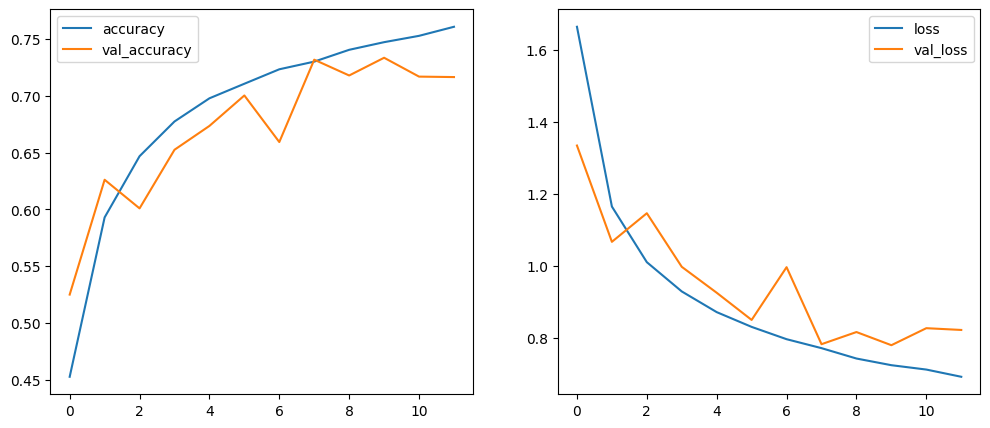

In [17]:
epochs = 20
number_of_convs = 2
activation_hidden = 'relu'
activation_output = 'softmax'
dropout_rate = 0.2
regularizer = None
optimizer = 'adam'

model_first, history_first = create_model(epochs, number_of_convs, activation_hidden, activation_output, dropout_rate, regularizer, optimizer)
draw_history_accuracy_and_loss(history_first)

Sieć się przeucza. Sprawdzę czy mniejsza sieć będzie podobna, bo jak tak to lepiej użyć mniejszej

Epoch 1/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.4142 - accuracy: 0.5062 - val_loss: 1.5214 - val_accuracy: 0.4670
Epoch 2/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0986 - accuracy: 0.6163 - val_loss: 1.0660 - val_accuracy: 0.6284
Epoch 3/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9883 - accuracy: 0.6585 - val_loss: 1.0853 - val_accuracy: 0.6254
Epoch 4/20
313/313 [==============================] - 1s 2ms/step


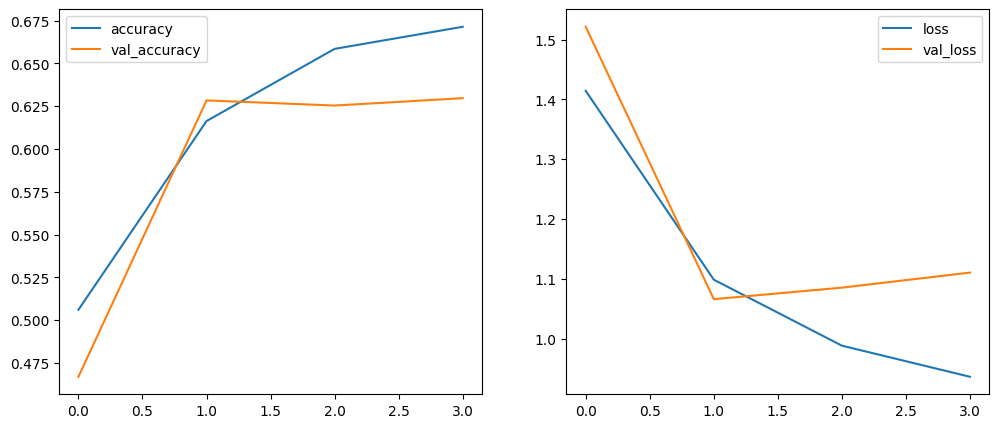

In [18]:
epochs = 20
number_of_convs = 1
activation_hidden = 'relu'
activation_output = 'softmax'
dropout_rate = 0.2
regularizer = None
optimizer = 'adam'

model_second, history_second = create_model(epochs, number_of_convs, activation_hidden, activation_output, dropout_rate, regularizer, optimizer)
draw_history_accuracy_and_loss(history_second)

Jednak większa sieć dała lepsze wyniki, więc wracam do poprzedniej wersji, ale z innym optimizerem

Epoch 1/20
1250/1250 [==============================] - 10s 7ms/step - loss: 1.6479 - accuracy: 0.4677 - val_loss: 1.2568 - val_accuracy: 0.5621
Epoch 2/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1262 - accuracy: 0.6109 - val_loss: 1.1401 - val_accuracy: 0.5974
Epoch 3/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9947 - accuracy: 0.6553 - val_loss: 0.9385 - val_accuracy: 0.6772
Epoch 4/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.9277 - accuracy: 0.6775 - val_loss: 0.9226 - val_accuracy: 0.6814
Epoch 5/20
1250/1250 [==============================] - 8s 7ms/step - loss: 0.8786 - accuracy: 0.6957 - val_loss: 0.9321 - val_accuracy: 0.6787
Epoch 6/20
313/313 [==============================] - 1s 2ms/step


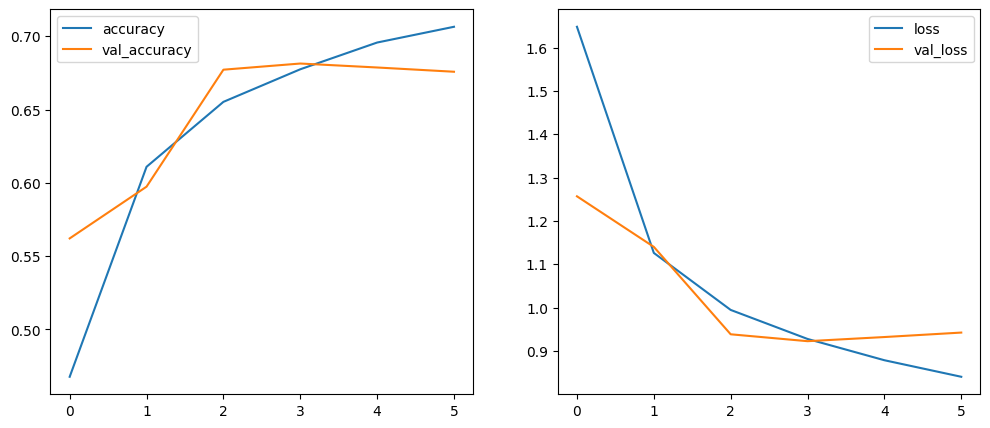

In [19]:
epochs = 20
number_of_convs = 2
activation_hidden = 'relu'
activation_output = 'softmax'
dropout_rate = 0.2
regularizer = None
optimizer = 'rmsprop'

model_third, history_third = create_model(epochs, number_of_convs, activation_hidden, activation_output, dropout_rate, regularizer, optimizer)
draw_history_accuracy_and_loss(history_third)

In [20]:
def show_all_metrics():
    global METRICS_AND_PARAMS
    metrics_df = pd.DataFrame(METRICS_AND_PARAMS).T
    metrics_df = metrics_df.sort_values(by="f1_score", ascending=False)
    return metrics_df

show_all_metrics()

,loss,f1_score,accuracy,epochs,number_of_layers,dropout_rate,regularizer,optimizer,activation_hidden,activation_output
0,0.823093,0.7165,0.7165,20,2,0.2,None,adam,relu,softmax
2,0.942441,0.6758,0.6758,20,2,0.2,None,rmsprop,relu,softmax
1,1.110454,0.6297,0.6297,20,1,0.2,None,adam,relu,softmax


Adam jednak okazał się być lepszy, przetestuję jeszczę Nadam

Epoch 1/20
1250/1250 [==============================] - 14s 8ms/step - loss: 1.6685 - accuracy: 0.4466 - val_loss: 1.5828 - val_accuracy: 0.4618
Epoch 2/20
1250/1250 [==============================] - 10s 8ms/step - loss: 1.1424 - accuracy: 0.6017 - val_loss: 1.0328 - val_accuracy: 0.6417
Epoch 3/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.9929 - accuracy: 0.6528 - val_loss: 1.0881 - val_accuracy: 0.6339
Epoch 4/20
313/313 [==============================] - 1s 3ms/step


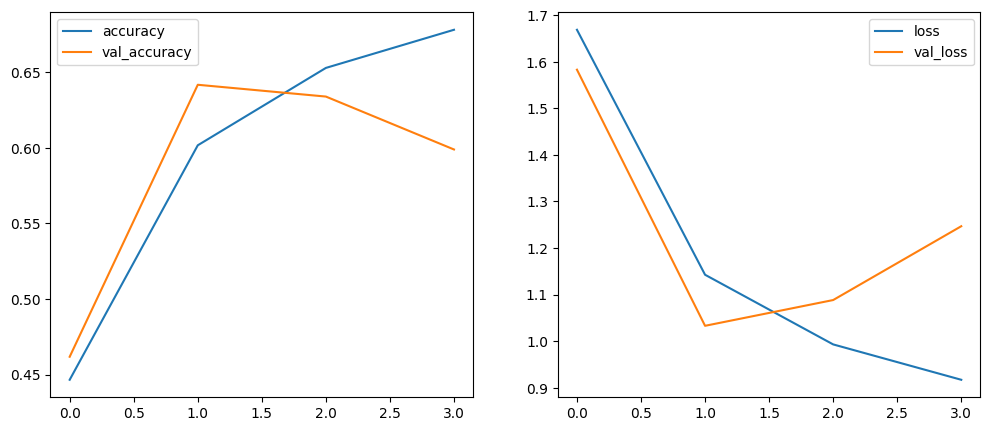

In [21]:
epochs = 20
number_of_convs = 2
activation_hidden = 'relu'
activation_output = 'softmax'
dropout_rate = 0.2
regularizer = None
optimizer = 'nadam'

model_4, history_4 = create_model(epochs, number_of_convs, activation_hidden, activation_output, dropout_rate, regularizer, optimizer)
draw_history_accuracy_and_loss(history_4)

In [22]:
show_all_metrics()

,loss,f1_score,accuracy,epochs,number_of_layers,dropout_rate,regularizer,optimizer,activation_hidden,activation_output
0,0.823093,0.7165,0.7165,20,2,0.2,None,adam,relu,softmax
2,0.942441,0.6758,0.6758,20,2,0.2,None,rmsprop,relu,softmax
1,1.110454,0.6297,0.6297,20,1,0.2,None,adam,relu,softmax
3,1.246646,0.5989,0.5989,20,2,0.2,None,nadam,relu,softmax


Wracam do wersji z optimizerem adam, dodam regularyzację

Epoch 1/20
1250/1250 [==============================] - 11s 7ms/step - loss: 1.6965 - accuracy: 0.4344 - val_loss: 1.4643 - val_accuracy: 0.5191
Epoch 2/20
1250/1250 [==============================] - 10s 8ms/step - loss: 1.1458 - accuracy: 0.6034 - val_loss: 1.0813 - val_accuracy: 0.6237
Epoch 3/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.9988 - accuracy: 0.6519 - val_loss: 0.9744 - val_accuracy: 0.6645
Epoch 4/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9249 - accuracy: 0.6784 - val_loss: 0.9351 - val_accuracy: 0.6693
Epoch 5/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8727 - accuracy: 0.6977 - val_loss: 0.9298 - val_accuracy: 0.6757
Epoch 6/20
1250/1250 [==============================] - 8s 7ms/step - loss: 0.8345 - accuracy: 0.7110 - val_loss: 0.8689 - val_accuracy: 0.7012
Epoch 7/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8065 - accuracy: 0.7183 - val_loss: 0.9154 - val_accurac

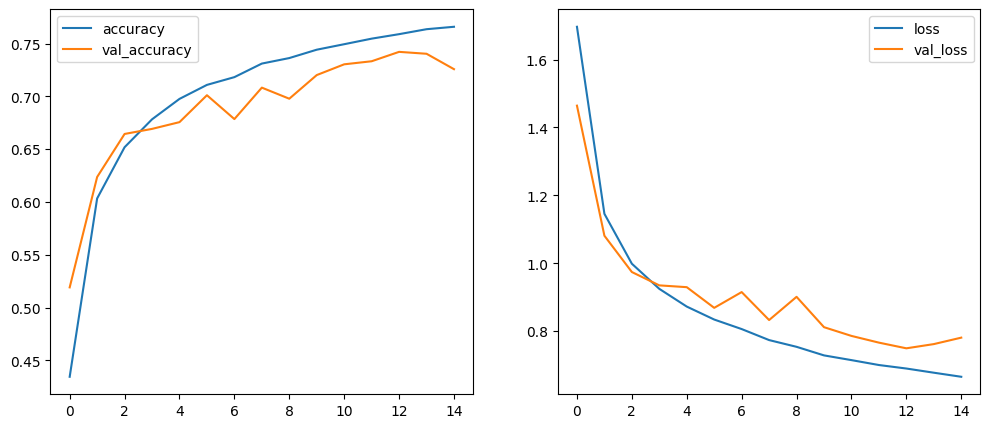

In [23]:
epochs = 20
number_of_convs = 2
activation_hidden = 'relu'
activation_output = 'softmax'
dropout_rate = 0.2
regularizer = 'l2'
optimizer = 'adam'

model_5, history_5 = create_model(epochs, number_of_convs, activation_hidden, activation_output, dropout_rate, regularizer, optimizer)
draw_history_accuracy_and_loss(history_5)

Wyniki są lepsze, ale zobaczę co da l1

Epoch 1/20
1250/1250 [==============================] - 10s 7ms/step - loss: 1.6602 - accuracy: 0.4534 - val_loss: 1.4422 - val_accuracy: 0.5125
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.1627 - accuracy: 0.5938 - val_loss: 1.0780 - val_accuracy: 0.6266
Epoch 3/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.0085 - accuracy: 0.6488 - val_loss: 0.9340 - val_accuracy: 0.6745
Epoch 4/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9221 - accuracy: 0.6779 - val_loss: 0.9949 - val_accuracy: 0.6496
Epoch 5/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8724 - accuracy: 0.6937 - val_loss: 0.8886 - val_accuracy: 0.6921
Epoch 6/20
1250/1250 [==============================] - 8s 7ms/step - loss: 0.8291 - accuracy: 0.7103 - val_loss: 0.8486 - val_accuracy: 0.7107
Epoch 7/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.7969 - accuracy: 0.7236 - val_loss: 0.8096 - val_accuracy

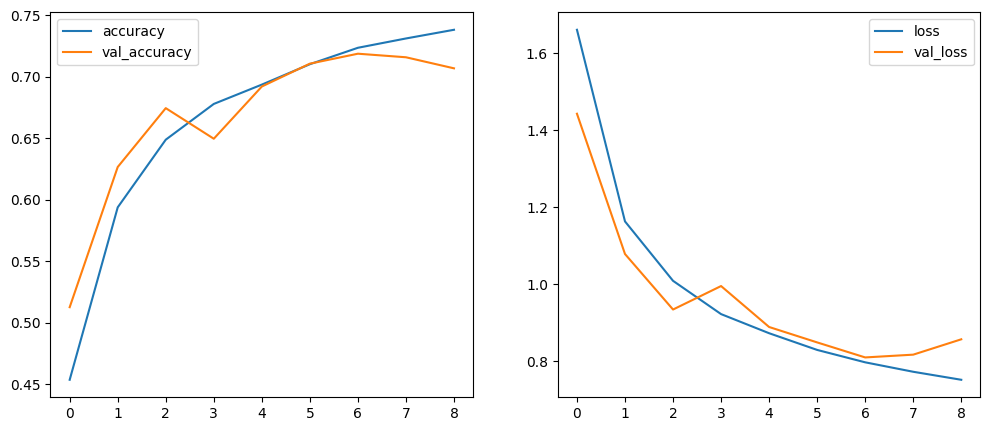

In [24]:
epochs = 20
number_of_convs = 2
activation_hidden = 'relu'
activation_output = 'softmax'
dropout_rate = 0.2
regularizer = 'l1'
optimizer = 'adam'

model_6, history_6 = create_model(epochs, number_of_convs, activation_hidden, activation_output, dropout_rate, regularizer, optimizer)
draw_history_accuracy_and_loss(history_6)

In [25]:
show_all_metrics()

,loss,f1_score,accuracy,epochs,number_of_layers,dropout_rate,regularizer,optimizer,activation_hidden,activation_output
4,0.781174,0.7259,0.7259,20,2,0.2,l2,adam,relu,softmax
0,0.823093,0.7165,0.7165,20,2,0.2,None,adam,relu,softmax
5,0.856632,0.7069,0.7069,20,2,0.2,l1,adam,relu,softmax
2,0.942441,0.6758,0.6758,20,2,0.2,None,rmsprop,relu,softmax
1,1.110454,0.6297,0.6297,20,1,0.2,None,adam,relu,softmax
3,1.246646,0.5989,0.5989,20,2,0.2,None,nadam,relu,softmax


Lepsze wyniki z regularyzacją. Sprawdzę obie na raz

Epoch 1/20
1250/1250 [==============================] - 11s 8ms/step - loss: 1.7123 - accuracy: 0.4339 - val_loss: 1.2457 - val_accuracy: 0.5642
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.1418 - accuracy: 0.6026 - val_loss: 1.2265 - val_accuracy: 0.5895
Epoch 3/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9888 - accuracy: 0.6549 - val_loss: 0.9701 - val_accuracy: 0.6656
Epoch 4/20
1250/1250 [==============================] - 8s 7ms/step - loss: 0.9223 - accuracy: 0.6764 - val_loss: 1.0063 - val_accuracy: 0.6508
Epoch 5/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8756 - accuracy: 0.6940 - val_loss: 0.8875 - val_accuracy: 0.7023
Epoch 6/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8435 - accuracy: 0.7054 - val_loss: 0.8781 - val_accuracy: 0.6928
Epoch 7/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.8091 - accuracy: 0.7177 - val_loss: 0.8448 - val_accuracy

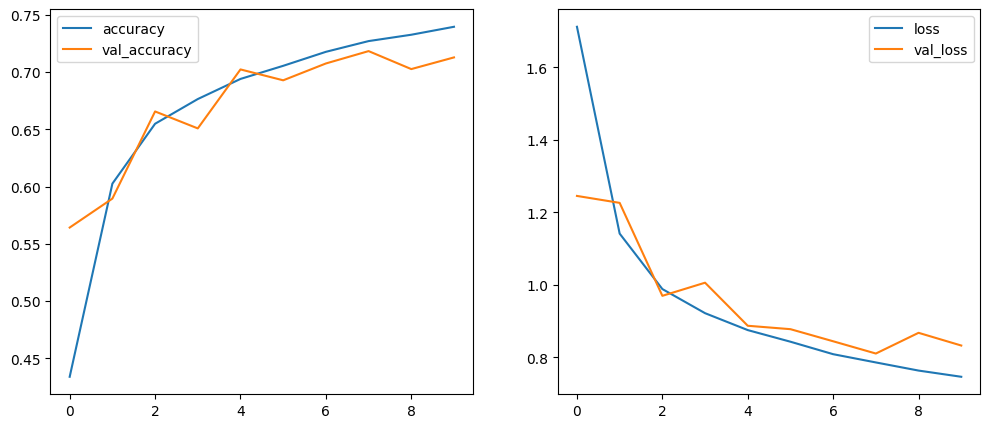

In [26]:
epochs = 20
number_of_convs = 2
activation_hidden = 'relu'
activation_output = 'softmax'
dropout_rate = 0.2
regularizer = 'l1_l2'
optimizer = 'adam'

model_7, history_7 = create_model(epochs, number_of_convs, activation_hidden, activation_output, dropout_rate, regularizer, optimizer)
draw_history_accuracy_and_loss(history_7)

In [27]:
show_all_metrics()

,loss,f1_score,accuracy,epochs,number_of_layers,dropout_rate,regularizer,optimizer,activation_hidden,activation_output
4,0.781174,0.7259,0.7259,20,2,0.2,l2,adam,relu,softmax
0,0.823093,0.7165,0.7165,20,2,0.2,None,adam,relu,softmax
6,0.833011,0.7128,0.7128,20,2,0.2,l1_l2,adam,relu,softmax
5,0.856632,0.7069,0.7069,20,2,0.2,l1,adam,relu,softmax
2,0.942441,0.6758,0.6758,20,2,0.2,None,rmsprop,relu,softmax
1,1.110454,0.6297,0.6297,20,1,0.2,None,adam,relu,softmax
3,1.246646,0.5989,0.5989,20,2,0.2,None,nadam,relu,softmax


Najlepiej wygląda sieć z indeksem 4, więc wróce do niej i przetestuję jeszcze inne funkcje aktywacji niż relu

Epoch 1/20
1250/1250 [==============================] - 11s 7ms/step - loss: 1.6984 - accuracy: 0.4408 - val_loss: 1.4010 - val_accuracy: 0.5200
Epoch 2/20
1250/1250 [==============================] - 8s 7ms/step - loss: 1.1873 - accuracy: 0.5896 - val_loss: 1.2213 - val_accuracy: 0.5823
Epoch 3/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0240 - accuracy: 0.6446 - val_loss: 1.0962 - val_accuracy: 0.6217
Epoch 4/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.9514 - accuracy: 0.6728 - val_loss: 0.9944 - val_accuracy: 0.6551
Epoch 5/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.9019 - accuracy: 0.6889 - val_loss: 0.9557 - val_accuracy: 0.6753
Epoch 6/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.8661 - accuracy: 0.7013 - val_loss: 0.9321 - val_accuracy: 0.6757
Epoch 7/20
1250/1250 [==============================] - 8s 7ms/step - loss: 0.8345 - accuracy: 0.7114 - val_loss: 0.8711 - val_accuracy

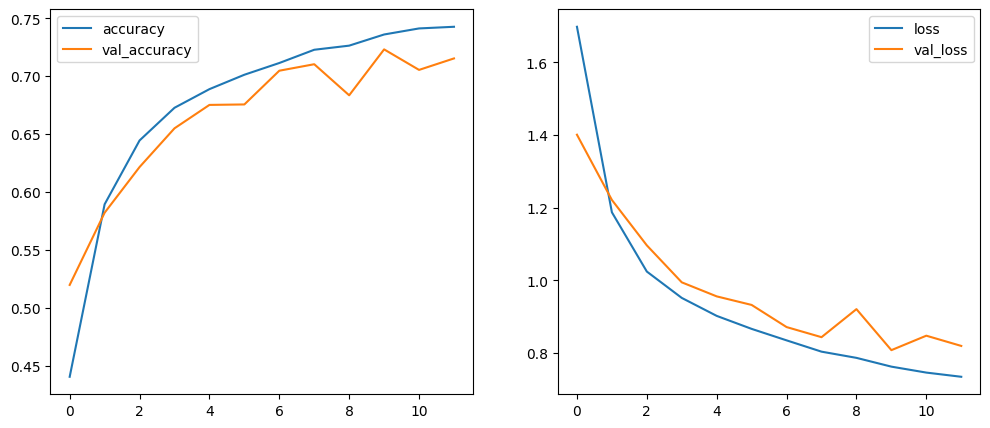

In [28]:
epochs = 20
number_of_convs = 2
activation_hidden = 'mish'
activation_output = 'softmax'
dropout_rate = 0.2
regularizer = 'l2'
optimizer = 'adam'

model_8, history_8 = create_model(epochs, number_of_convs, activation_hidden, activation_output, dropout_rate, regularizer, optimizer)
draw_history_accuracy_and_loss(history_8)

In [29]:
show_all_metrics()

,loss,f1_score,accuracy,epochs,number_of_layers,dropout_rate,regularizer,optimizer,activation_hidden,activation_output
4,0.781174,0.7259,0.7259,20,2,0.2,l2,adam,relu,softmax
0,0.823093,0.7165,0.7165,20,2,0.2,None,adam,relu,softmax
7,0.819176,0.7154,0.7154,20,2,0.2,l2,adam,mish,softmax
6,0.833011,0.7128,0.7128,20,2,0.2,l1_l2,adam,relu,softmax
5,0.856632,0.7069,0.7069,20,2,0.2,l1,adam,relu,softmax
2,0.942441,0.6758,0.6758,20,2,0.2,None,rmsprop,relu,softmax
1,1.110454,0.6297,0.6297,20,1,0.2,None,adam,relu,softmax
3,1.246646,0.5989,0.5989,20,2,0.2,None,nadam,relu,softmax


Mish dalo gorsze wyniki. Przetestuję leaky_relu

Epoch 1/20
1250/1250 [==============================] - 10s 6ms/step - loss: 1.6543 - accuracy: 0.4494 - val_loss: 1.4343 - val_accuracy: 0.5081
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.1361 - accuracy: 0.6074 - val_loss: 1.4787 - val_accuracy: 0.5296
Epoch 3/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0012 - accuracy: 0.6527 - val_loss: 1.0331 - val_accuracy: 0.6513
Epoch 4/20
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9323 - accuracy: 0.6760 - val_loss: 0.9807 - val_accuracy: 0.6669
Epoch 5/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.8855 - accuracy: 0.6934 - val_loss: 1.0756 - val_accuracy: 0.6337
Epoch 6/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8547 - accuracy: 0.7045 - val_loss: 0.9252 - val_accuracy: 0.6850
Epoch 7/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.8244 - accuracy: 0.7150 - val_loss: 0.9195 - val_accurac

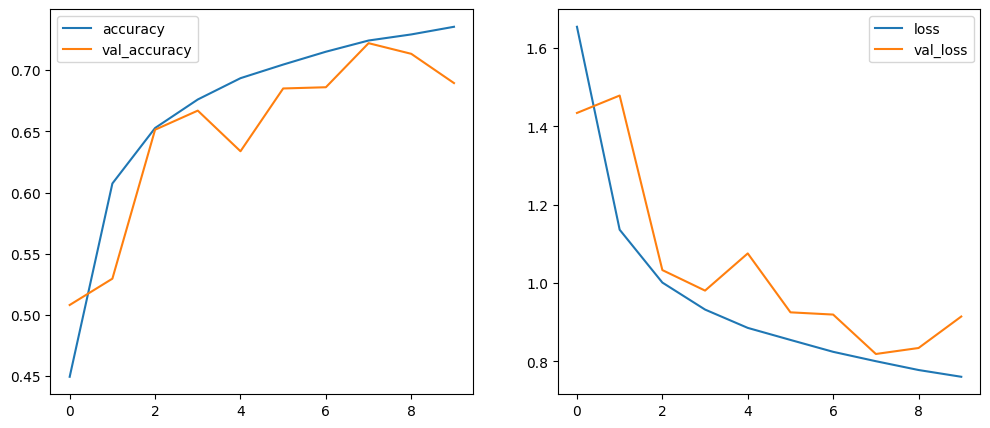

In [30]:
epochs = 20
number_of_convs = 2
activation_hidden = 'leaky_relu'
activation_output = 'softmax'
dropout_rate = 0.2
regularizer = 'l2'
optimizer = 'adam'

model_9, history_9 = create_model(epochs, number_of_convs, activation_hidden, activation_output, dropout_rate, regularizer, optimizer)
draw_history_accuracy_and_loss(history_9)

In [31]:
show_all_metrics()

,loss,f1_score,accuracy,epochs,number_of_layers,dropout_rate,regularizer,optimizer,activation_hidden,activation_output
4,0.781174,0.7259,0.7259,20,2,0.2,l2,adam,relu,softmax
0,0.823093,0.7165,0.7165,20,2,0.2,None,adam,relu,softmax
7,0.819176,0.7154,0.7154,20,2,0.2,l2,adam,mish,softmax
6,0.833011,0.7128,0.7128,20,2,0.2,l1_l2,adam,relu,softmax
5,0.856632,0.7069,0.7069,20,2,0.2,l1,adam,relu,softmax
8,0.914513,0.6894,0.6894,20,2,0.2,l2,adam,leaky_relu,softmax
2,0.942441,0.6758,0.6758,20,2,0.2,None,rmsprop,relu,softmax
1,1.110454,0.6297,0.6297,20,1,0.2,None,adam,relu,softmax
3,1.246646,0.5989,0.5989,20,2,0.2,None,nadam,relu,softmax


Zostaję przy wersji relu, ma najniższy loss. Zobaczę niższy dropoput

Epoch 1/20
1250/1250 [==============================] - 11s 7ms/step - loss: 1.5926 - accuracy: 0.4593 - val_loss: 1.4136 - val_accuracy: 0.5233
Epoch 2/20
1250/1250 [==============================] - 11s 9ms/step - loss: 1.1258 - accuracy: 0.6073 - val_loss: 1.2276 - val_accuracy: 0.5880
Epoch 3/20
1250/1250 [==============================] - 12s 9ms/step - loss: 0.9663 - accuracy: 0.6646 - val_loss: 1.1601 - val_accuracy: 0.6235
Epoch 4/20
1250/1250 [==============================] - 11s 9ms/step - loss: 0.8810 - accuracy: 0.6967 - val_loss: 0.9027 - val_accuracy: 0.6933
Epoch 5/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.8276 - accuracy: 0.7124 - val_loss: 0.9136 - val_accuracy: 0.6872
Epoch 6/20
313/313 [==============================] - 1s 2ms/step


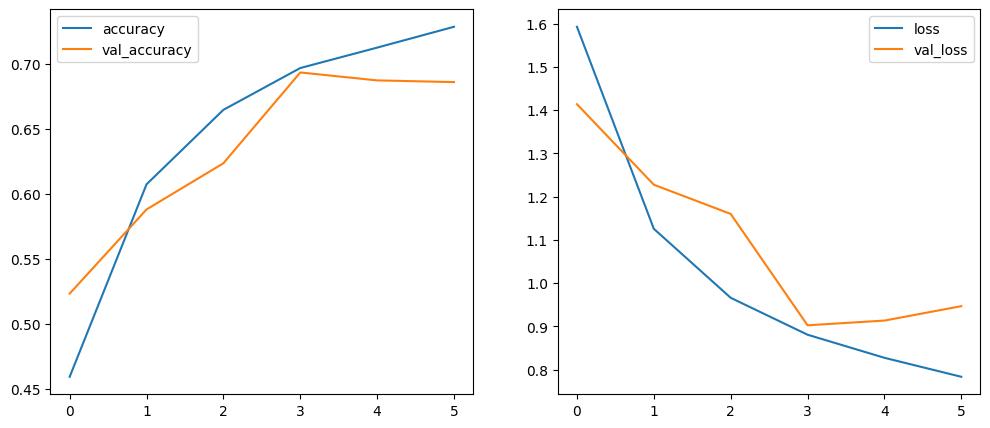

,loss,f1_score,accuracy,epochs,number_of_layers,dropout_rate,regularizer,optimizer,activation_hidden,activation_output
4,0.781174,0.7259,0.7259,20,2,0.2,l2,adam,relu,softmax
0,0.823093,0.7165,0.7165,20,2,0.2,None,adam,relu,softmax
7,0.819176,0.7154,0.7154,20,2,0.2,l2,adam,mish,softmax
6,0.833011,0.7128,0.7128,20,2,0.2,l1_l2,adam,relu,softmax
5,0.856632,0.7069,0.7069,20,2,0.2,l1,adam,relu,softmax
8,0.914513,0.6894,0.6894,20,2,0.2,l2,adam,leaky_relu,softmax
9,0.946903,0.6859,0.6859,20,2,0.1,l2,adam,relu,softmax
2,0.942441,0.6758,0.6758,20,2,0.2,None,rmsprop,relu,softmax
1,1.110454,0.6297,0.6297,20,1,0.2,None,adam,relu,softmax
3,1.246646,0.5989,0.5989,20,2,0.2,None,nadam,relu,softmax


In [32]:
epochs = 20
number_of_convs = 2
activation_hidden = 'relu'
activation_output = 'softmax'
dropout_rate = 0.1
regularizer = 'l2'
optimizer = 'adam'

model_10, history_10 = create_model(epochs, number_of_convs, activation_hidden, activation_output, dropout_rate, regularizer, optimizer)
draw_history_accuracy_and_loss(history_10)
show_all_metrics()

Średnio to zadziałało. Zwiększę dropout

Epoch 1/20
1250/1250 [==============================] - 11s 7ms/step - loss: 1.8062 - accuracy: 0.4102 - val_loss: 1.3583 - val_accuracy: 0.5247
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.2817 - accuracy: 0.5467 - val_loss: 1.2888 - val_accuracy: 0.5550
Epoch 3/20
1250/1250 [==============================] - 8s 7ms/step - loss: 1.1154 - accuracy: 0.6062 - val_loss: 1.0963 - val_accuracy: 0.6250
Epoch 4/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0300 - accuracy: 0.6377 - val_loss: 1.0996 - val_accuracy: 0.6174
Epoch 5/20
1250/1250 [==============================] - 8s 7ms/step - loss: 0.9712 - accuracy: 0.6586 - val_loss: 0.9706 - val_accuracy: 0.6652
Epoch 6/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.9319 - accuracy: 0.6741 - val_loss: 0.9304 - val_accuracy: 0.6770
Epoch 7/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9036 - accuracy: 0.6816 - val_loss: 0.9114 - val_accuracy

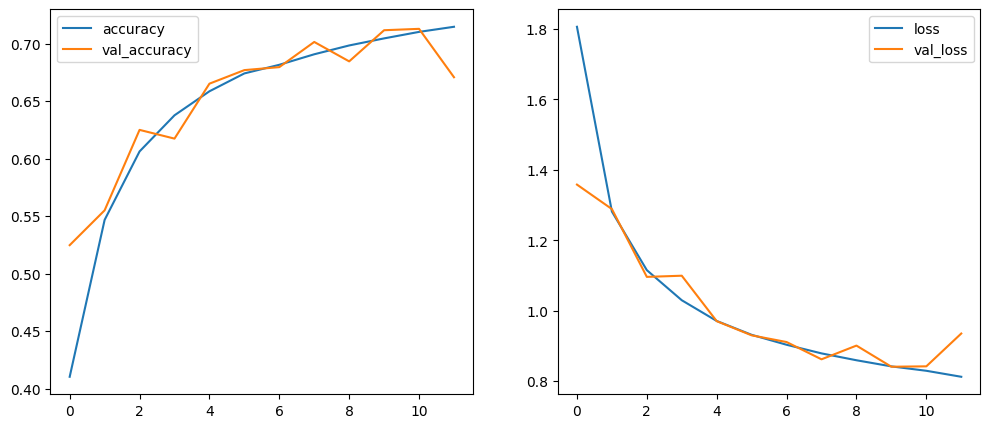

,loss,f1_score,accuracy,epochs,number_of_layers,dropout_rate,regularizer,optimizer,activation_hidden,activation_output
4,0.781174,0.7259,0.7259,20,2,0.2,l2,adam,relu,softmax
0,0.823093,0.7165,0.7165,20,2,0.2,None,adam,relu,softmax
7,0.819176,0.7154,0.7154,20,2,0.2,l2,adam,mish,softmax
6,0.833011,0.7128,0.7128,20,2,0.2,l1_l2,adam,relu,softmax
5,0.856632,0.7069,0.7069,20,2,0.2,l1,adam,relu,softmax
8,0.914513,0.6894,0.6894,20,2,0.2,l2,adam,leaky_relu,softmax
9,0.946903,0.6859,0.6859,20,2,0.1,l2,adam,relu,softmax
2,0.942441,0.6758,0.6758,20,2,0.2,None,rmsprop,relu,softmax
10,0.935526,0.6708,0.6708,20,2,0.3,l2,adam,relu,softmax
1,1.110454,0.6297,0.6297,20,1,0.2,None,adam,relu,softmax


In [33]:
epochs = 20
number_of_convs = 2
activation_hidden = 'relu'
activation_output = 'softmax'
dropout_rate = 0.3
regularizer = 'l2'
optimizer = 'adam'

model_11, history_11 = create_model(epochs, number_of_convs, activation_hidden, activation_output, dropout_rate, regularizer, optimizer)
draw_history_accuracy_and_loss(history_11)
show_all_metrics()

Jako najlepszy model wybieram ten z indeksem 4. Przetestuję go jeszcze na danych po augumentacji

In [35]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    zoom_range = 0.2)

datagen.fit(x_train)

augmented_data_generator = datagen.flow(x_train, y_train, batch_size=4)

## PONIŻSZY BŁĄD ZOSTAWIŁAM SPECJALNIE - chciałam pokazać, ze sieć się nie uczy, zostawiam sieć bez augumentacji

In [36]:
epochs = 20
number_of_convs = 2
activation_hidden = 'relu'
activation_output = 'softmax'
dropout_rate = 0.2
regularizer = 'l2'
optimizer = 'adam'

model_aug = Sequential()
model_aug.add(Conv2D(32, KERNEL_SIZE, activation = activation_hidden, padding = 'same', input_shape = INPUT_SHAPE))

for i in range(number_of_convs):
  model_aug.add(Conv2D(32, KERNEL_SIZE, activation = activation_hidden, padding = 'same'))
  model_aug.add(BatchNormalization())
  model_aug.add(MaxPooling2D(2, 2))
  model_aug.add(Dropout(dropout_rate))

model_aug.add(Flatten())
model_aug.add(Dense(10, activation = activation_output))

early_stopping = EarlyStopping(patience = 2, monitor='val_loss')

model_aug.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history_aug = model_aug.fit(augmented_data_generator,
                    epochs = epochs,
                    validation_data = (x_val, y_val),
                    callbacks = [early_stopping])

draw_history_accuracy_and_loss(history_aug)

Epoch 1/20
10000/10000 [==============================] - 77s 7ms/step - loss: 1.7517 - accuracy: 0.1014 - val_loss: 1.3171 - val_accuracy: 0.0708
Epoch 2/20
10000/10000 [==============================] - 85s 8ms/step - loss: 1.3432 - accuracy: 0.1027 - val_loss: 1.2070 - val_accuracy: 0.0772
Epoch 3/20
10000/10000 [==============================] - 76s 8ms/step - loss: 1.2361 - accuracy: 0.1028 - val_loss: 1.1196 - val_accuracy: 0.0796
Epoch 4/20
10000/10000 [==============================] - 80s 8ms/step - loss: 1.1650 - accuracy: 0.1028 - val_loss: 1.1352 - val_accuracy: 0.0868
Epoch 5/20
10000/10000 [==============================] - 75s 7ms/step - loss: 1.1357 - accuracy: 0.1011 - val_loss: 0.9961 - val_accuracy: 0.0926
Epoch 6/20
10000/10000 [==============================] - 76s 8ms/step - loss: 1.1001 - accuracy: 0.1012 - val_loss: 1.0540 - val_accuracy: 0.0923
Epoch 7/20
 8735/10000 [=========================>....] - ETA: 9s - loss: 1.0789 - accuracy: 0.1024

KeyboardInterrupt: ignored

In [37]:
!pip install visualkeras

Wizualizacja finalnej sieci

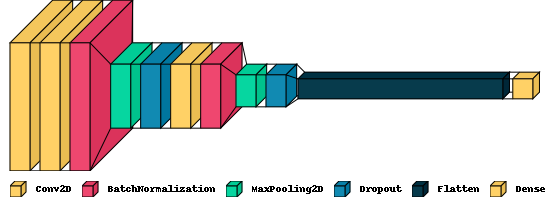

In [38]:
import visualkeras

visualkeras.layered_view(model_5, legend=True)

Predykcja na zbiorze testowym

313/313 [==============================] - 1s 3ms/step


([<matplotlib.patches.Wedge at 0x7e429ecdcf40>,
 [Text(-0.7256268133496178, 0.826719860501778, 'correct'),
  Text(0.7256268907527136, -0.8267197925636894, 'incorrect')],
 [Text(-0.395796443645246, 0.4509381057282425, '72.9%'),
  Text(0.39579648586511645, -0.45093806867110325, '27.1%')])

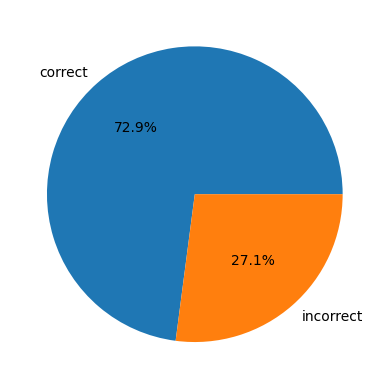

In [39]:
y_pred = tf.argmax(model_5.predict(x_test), axis=1)

y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_test_df = pd.DataFrame(y_test, columns=['y_test'])

compare_df = pd.concat([y_pred_df, y_test_df], axis=1)

compare_df['correct'] = np.where(compare_df['y_pred'] == compare_df['y_test'], 1, 0)
plt.pie(compare_df['correct'].value_counts(), labels=['correct', 'incorrect'], autopct='%1.1f%%')

Model zaklasyfikował 72,9% danych testowych poprawnie

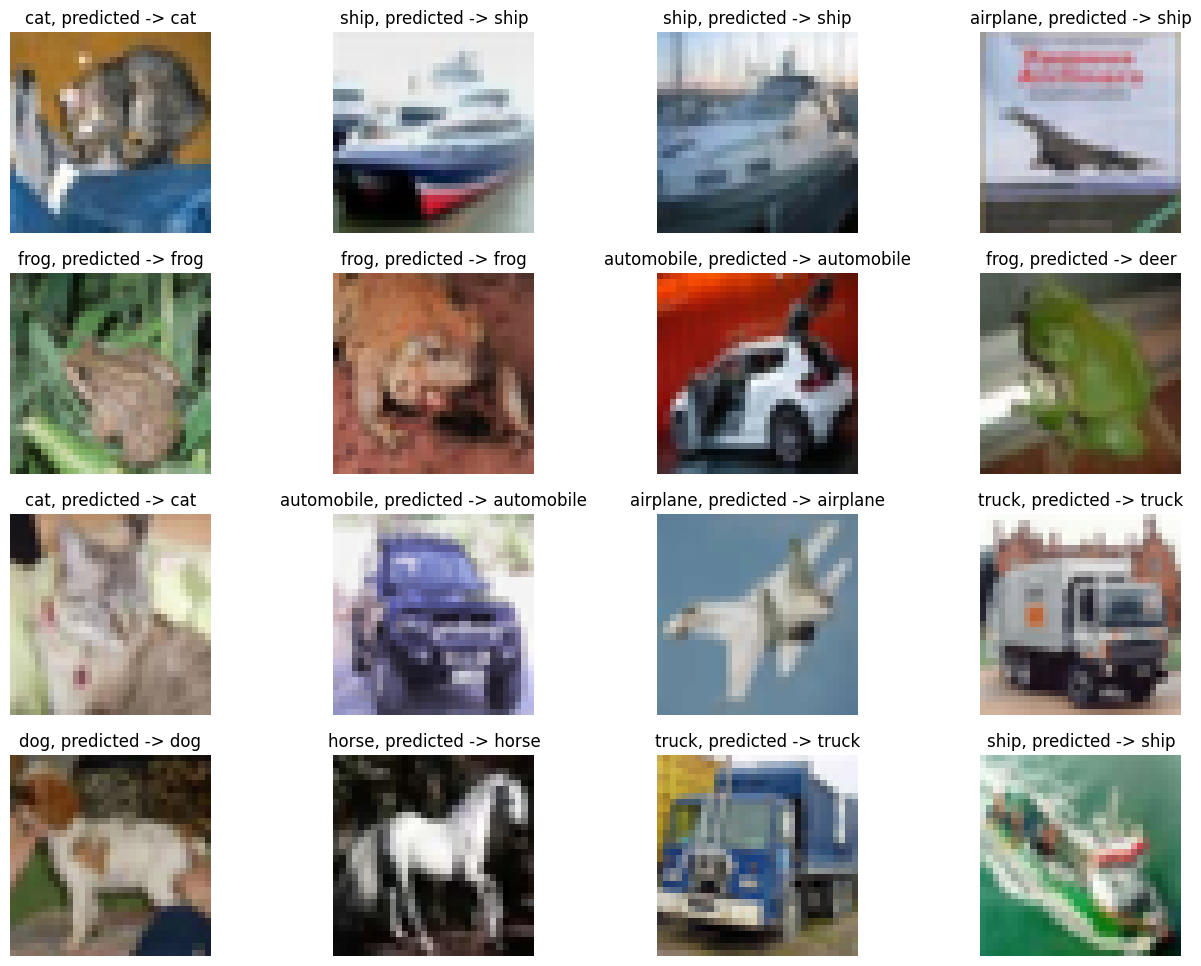

In [46]:
plt.figure(figsize=(16, 12))
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(x_test[i])
  plt.title(f"{labels[y_test[i][0]]}, predicted -> {labels[y_pred[i]]}")
  plt.axis("off")
plt.show()